In [1]:
import torch
import torchvision
from torchvision import transforms
train_data = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

c:\Users\qmirz\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 26421880/26421880 [01:31<00:00, 288271.53it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 89808.81it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:20<00:00, 212705.04it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 5119079.42it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [5]:
img_size = train_data[0][0].shape[1]
num_classes = len(train_data.classes)
input_size = train_data[0][0].shape[0]

print(f"Image Size:{img_size}x{img_size}\nNumber of Classes:{num_classes}\nInput Size: {input_size} channel(s)")

Image Size:28x28
Number of Classes:10
Input Size: 1 channel(s)


In [16]:
import torch.nn as nn
class MultiClassCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultiClassCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=16, kernel_size=2, stride=2) # 16X14X14
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 16x7x7
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2) # 32x3x3
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 32x1x1

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [17]:
model = MultiClassCNN(input_size, num_classes)
print(model)

MultiClassCNN(
  (conv1): Conv2d(1, 16, kernel_size=(2, 2), stride=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=32, out_features=10, bias=True)
)


In [18]:
from torchsummary import summary
summary(model, (input_size, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]              80
              ReLU-2           [-1, 16, 14, 14]               0
         MaxPool2d-3             [-1, 16, 7, 7]               0
            Conv2d-4             [-1, 32, 3, 3]           4,640
              ReLU-5             [-1, 32, 3, 3]               0
         MaxPool2d-6             [-1, 32, 1, 1]               0
           Flatten-7                   [-1, 32]               0
            Linear-8                   [-1, 10]             330
Total params: 5,050
Trainable params: 5,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.02
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
n_total_steps = len(train_loader)
num_epochs = 100
losses_per_epoch = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [64, 1, 28, 28]
        # input_layer: 1 input channel, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    losses_per_epoch.append(loss.item())

Epoch [1/100], Step [100/938], Loss: 0.4922
Epoch [1/100], Step [200/938], Loss: 0.5095
Epoch [1/100], Step [300/938], Loss: 0.5505
Epoch [1/100], Step [400/938], Loss: 0.2560
Epoch [1/100], Step [500/938], Loss: 0.5053
Epoch [1/100], Step [600/938], Loss: 0.3397
Epoch [1/100], Step [700/938], Loss: 0.4620
Epoch [1/100], Step [800/938], Loss: 0.3195
Epoch [1/100], Step [900/938], Loss: 0.3083
Epoch [2/100], Step [100/938], Loss: 0.4963
Epoch [2/100], Step [200/938], Loss: 0.4777
Epoch [2/100], Step [300/938], Loss: 0.4872
Epoch [2/100], Step [400/938], Loss: 0.6691
Epoch [2/100], Step [500/938], Loss: 0.3110
Epoch [2/100], Step [600/938], Loss: 0.5847
Epoch [2/100], Step [700/938], Loss: 0.3063
Epoch [2/100], Step [800/938], Loss: 0.4120
Epoch [2/100], Step [900/938], Loss: 0.4865
Epoch [3/100], Step [100/938], Loss: 0.3953
Epoch [3/100], Step [200/938], Loss: 0.4662
Epoch [3/100], Step [300/938], Loss: 0.4156
Epoch [3/100], Step [400/938], Loss: 0.3887
Epoch [3/100], Step [500/938], L

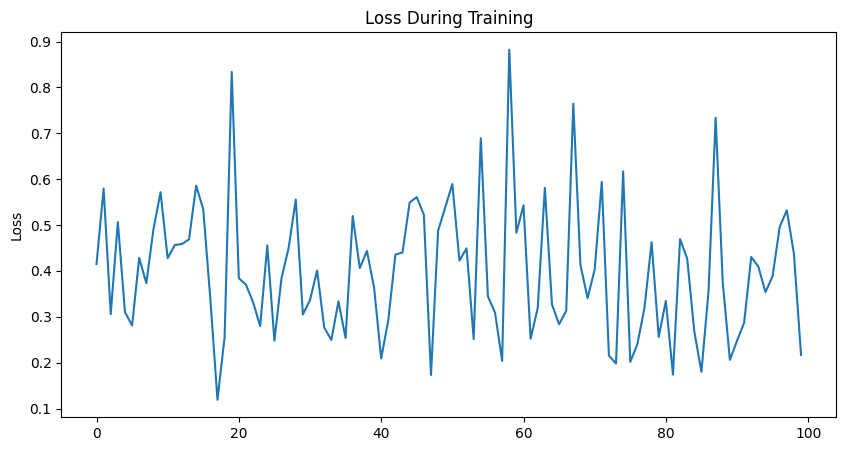

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.ylabel("Loss")
plt.plot(losses_per_epoch, label="Loss")
plt.show()


In [28]:
# Evaluate the model
model.eval()

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 85.12 %
